In [2]:
# https://www.tensorflow.org/tutorials/keras/text_classification

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
print(tf.__version__)

2.6.0-rc0


In [3]:
# Sentiment analysis. (Download and extract the dataset)
"""This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review"""

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84140032/84125825 [==============================] - 19s 0us/step


In [4]:
# Directory structure.
os.listdir(dataset_dir)

['README', 'test', 'imdb.vocab', 'train', 'imdbEr.txt']

In [5]:
# Train dir.
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'labeledBow.feat',
 'unsupBow.feat']

In [11]:
# Directories contain many text files, each of which is a single movie review.
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the dataset.

In [7]:
# Remove dataset additional folders.
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
# Create a validation set. (80:20)
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-08-08 07:07:18.132382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.
# The labels are 0 or 1. 
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a 

In [13]:
# To see which of these correspond to positive and negative movie reviews, you can check the class_names property on the dataset.
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [14]:
# Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.
# Validation.
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
# Test.
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training.

In [17]:
# Next, you will standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [18]:
# Next, you will create a TextVectorization layer.
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [19]:
# Next, you will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.
# Make a text-only dataset (without labels), then call adapt.
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [20]:
# Let's create a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [21]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[9257,   15,   28,    5,    2,  241,   91,    5,   30,   58,    4,
           1, 1011,   36,  262,   38,    9, 3891,   35,    2,    1,   43,
         382, 5223,   16,    4, 1113,   12,   43, 5739,  300,    2,   83,
         225,   55, 3209, 3898,   20,  973,   18,   51,   55, 3209,  250,
         320,   34,   40, 4386,    3,  294,   58,   44,    6, 2911,    4,
        6757,   92,   22,  184,    2, 4916,  100, 1221,  336,  161, 

In [24]:
# As you can see above, each token has been replaced by an integer. You can lookup the token (string) that
# each integer corresponds to by calling .get_vocabulary() on the layer.
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [23]:
# You are nearly ready to train your model. As a final preprocessing step, you will apply
# the TextVectorization layer you created earlier to the train, validation, and test dataset.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance.
These are two important methods you should use when loading data to make sure that I/O does not become blocking.
- .cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
- .prefetch() overlaps data preprocessing and model execution while training.

In [25]:
# Example.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the model.

In [26]:
# Create a neural network.
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:
- The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, see the word embedding tutorial.
- Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
- This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
- The last layer is densely connected with a single output node.

# Loss function and optimizer.

In [27]:
# Configure the model to use an optimizer and a loss function.
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [28]:
# Train model.
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 9s 14ms/step - loss: 0.6639 - binary_accuracy: 0.6935 - val_loss: 0.6149 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 3s 6ms/step - loss: 0.5484 - binary_accuracy: 0.8013 - val_loss: 0.4988 - val_binary_accuracy: 0.8250
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4451 - binary_accuracy: 0.8440 - val_loss: 0.4207 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3784 - binary_accuracy: 0.8667 - val_loss: 0.3739 - val_binary_accuracy: 0.8620
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3361 - binary_accuracy: 0.8795 - val_loss: 0.3452 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3048 - binary_accuracy: 0.8892 - val_loss: 0.3260 - val_binary_accuracy: 0.8730
Epoch 7/10
625/625 [==============================] - 5s 9ms/st

In [29]:
# Evaluate the model.
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3104 - binary_accuracy: 0.8737
Loss:  0.3104196786880493
Accuracy:  0.8736799955368042


In [30]:
# Create a plot of accuracy and loss over time.
# model.fit() returns a History object that contains a dictionary with everything that happened during training.
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

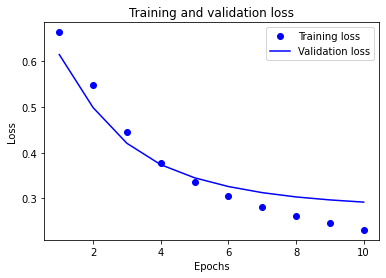

In [31]:
# There are four entries: one for each monitored metric during training and validation. 
# You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy.
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

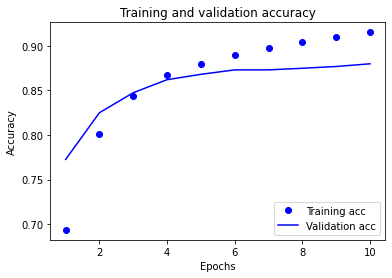

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Export the model.

In the code above, you applied the TextVectorization layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the TextVectorization layer inside your model. To do so, you can create a new model using the weights you just trained.

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3104 - accuracy: 0.8737
0.8736799955368042


In [34]:
# Inference on new data.
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


array([[0.6200862 ],
       [0.4445201 ],
       [0.36189127]], dtype=float32)

In [35]:
model

In [36]:
export_model